In [3]:
import pickle
import os
from typing import List, Dict, Tuple

class FLConfiguration:
    def __init__(self, date, time, db, alpha, strat_variant, d, ck, opt, dur, rounds=None):
        self.date = date
        self.time = time # time when the simulation was run
        self.db = db
        self.alpha = alpha
        self.variant = strat_variant
        self.d = d
        self.ck = ck
        self.opt = opt
        self.clients = 10
        self.rounds = rounds
        self.duration = dur # how long it took

    def __str__(self):
        return '{}/{}/'.format(self.date, self.time) + '_'.join([self.db, self.variant, 'd{}'.format(self.d), 'CK{}'.format(self.ck)])

In [4]:
# Find all results.pkl files in 'outputs' folder

EXPERIMENTS: List[FLConfiguration] = []
for alpha in os.listdir('outputs'):
    if alpha.startswith('.'):
        continue
    for day in os.listdir(os.path.join('outputs', alpha)):
        if day.startswith('.'):
            continue
        for time in os.listdir(os.path.join('outputs', alpha, day)):
            if time.startswith('.'):
                continue
            for exp in os.listdir(os.path.join('outputs', alpha, day, time)):
                if exp.startswith('.'):
                    continue           
                curr_folder = os.path.join('outputs', alpha, day, time, exp)
                if os.path.isdir(curr_folder) and 'results.pkl' in os.listdir(curr_folder):
                    fields = exp.split('_')
                    d = int(fields[2].replace('d', ''))
                    ck = int(fields[3].replace('CK', ''))
                    a = float(alpha.replace('alpha', ''))
    
                    log_file = [f for f in os.listdir(curr_folder) if '.log' in f][0]
                    opt = log_file.split('_')[1].replace('.log', '')
    
                    with open(curr_folder + '/' + log_file) as log:
                        lines = log.readlines()
                        try:
                            dur = [l for l in lines if 'FL finished in' in l][0]
                            dur = float(dur.split('FL finished in ')[1].replace('\n', ''))
                        except IndexError:
                            print('{} did not complete successfully.'.format(exp))
                            continue
                    
                    EXPERIMENTS.append(FLConfiguration(day, time, fields[0], a, fields[1], d, ck, opt, dur))

# Parse found .pkl files

data = []
results: Dict[FLConfiguration, Tuple[List[float], List[float]]] = {}
for exp in EXPERIMENTS:
    file_path = 'outputs/alpha{}/{}/results.pkl'.format(exp.alpha, str(exp))
    with open(file_path, 'rb') as file:
        data.append(pickle.load(file))
        # Accuracy and loss evolution for a single experiments over the different rounds
        latest_acc = [tup[1] for tup in data[-1]['history'].metrics_centralized['accuracy']]
        latest_loss = [tup[1] for tup in data[-1]['history'].losses_centralized]
        exp.rounds = len(latest_acc)
        results[exp] = (latest_acc, latest_loss)

print('Found {} experiments'.format(len(EXPERIMENTS)))

Found 154 experiments


/var/folders/wf/vl_sy5yj7fjgz0r9rn5xbvf00000gn/T/ipykernel_27587/1265512429.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


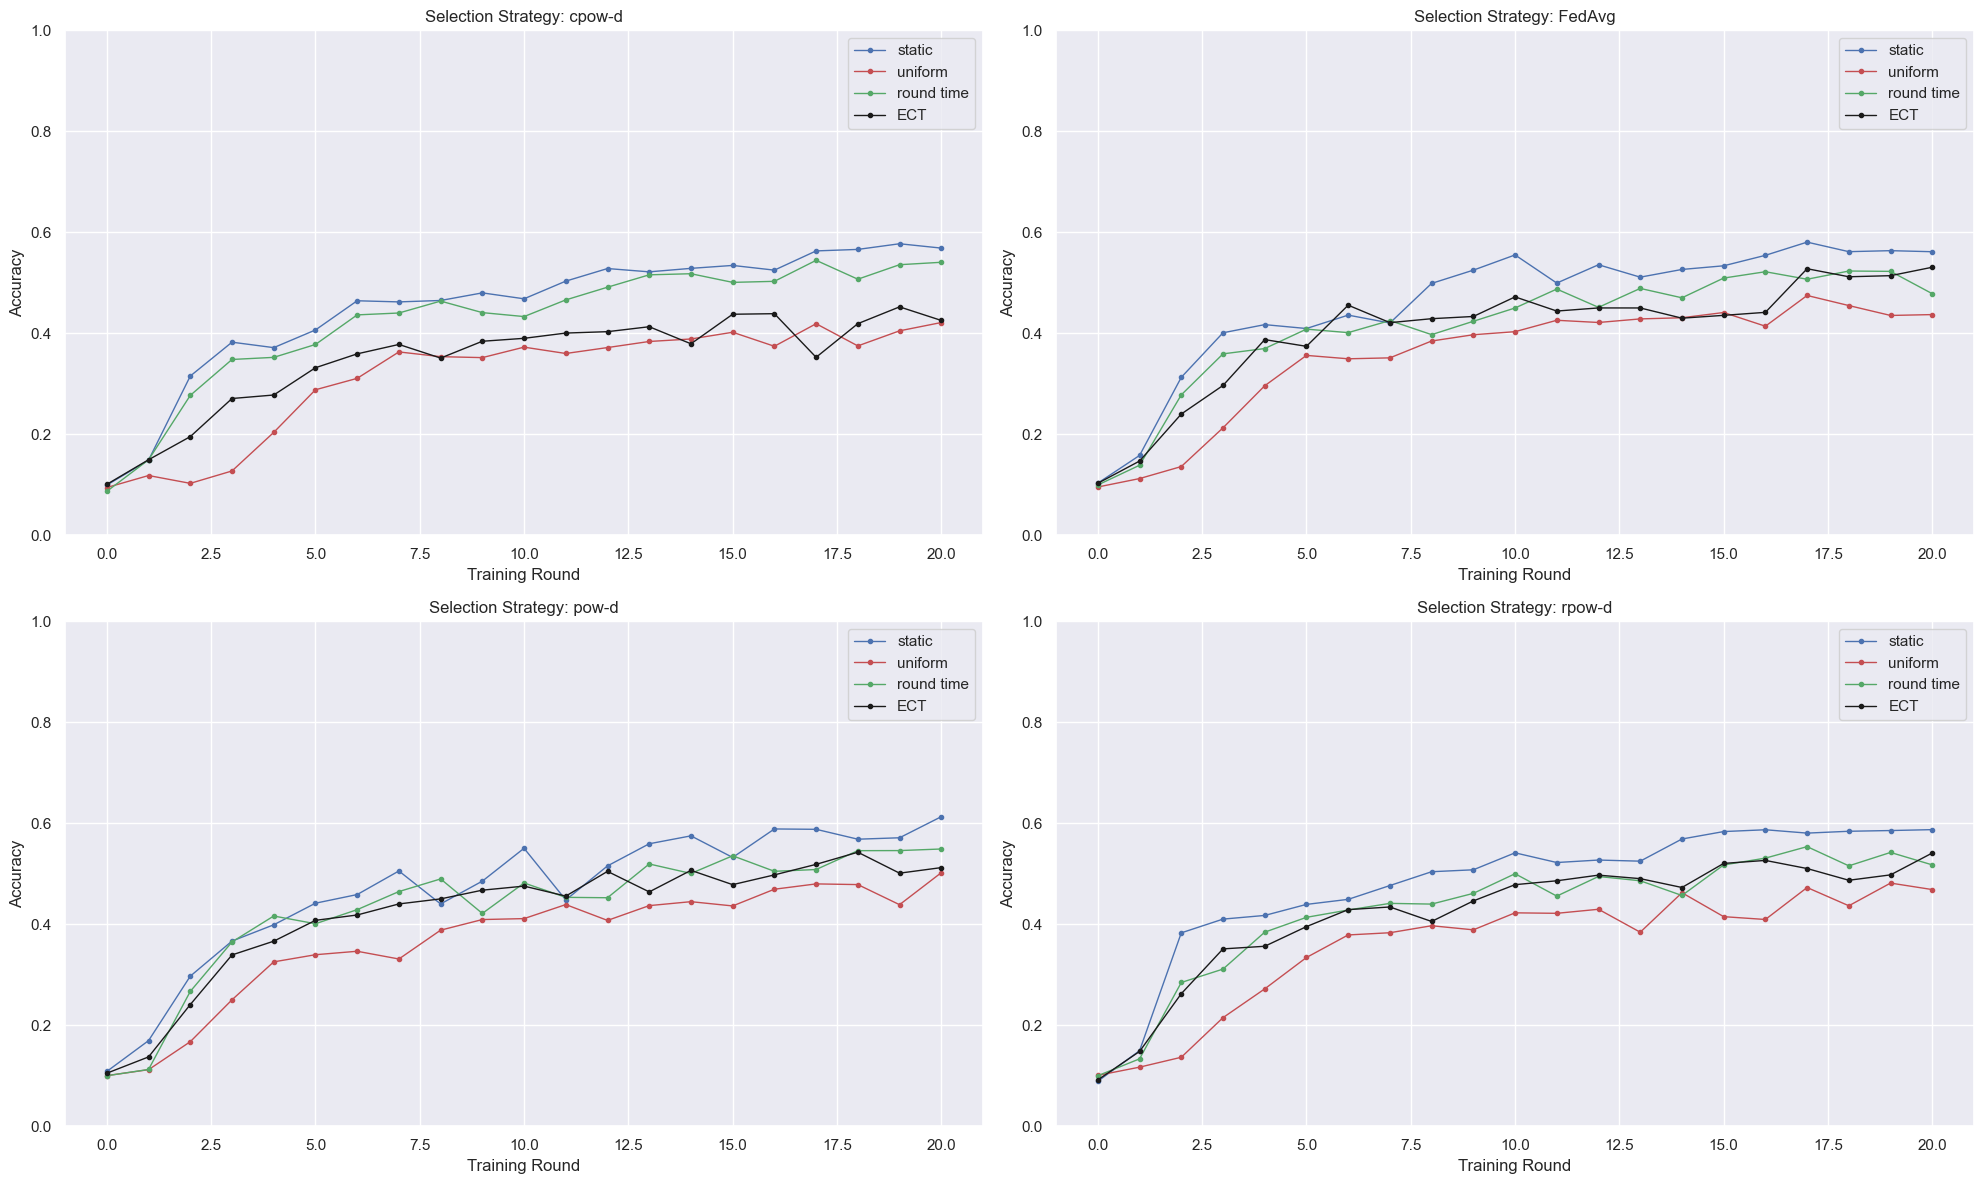

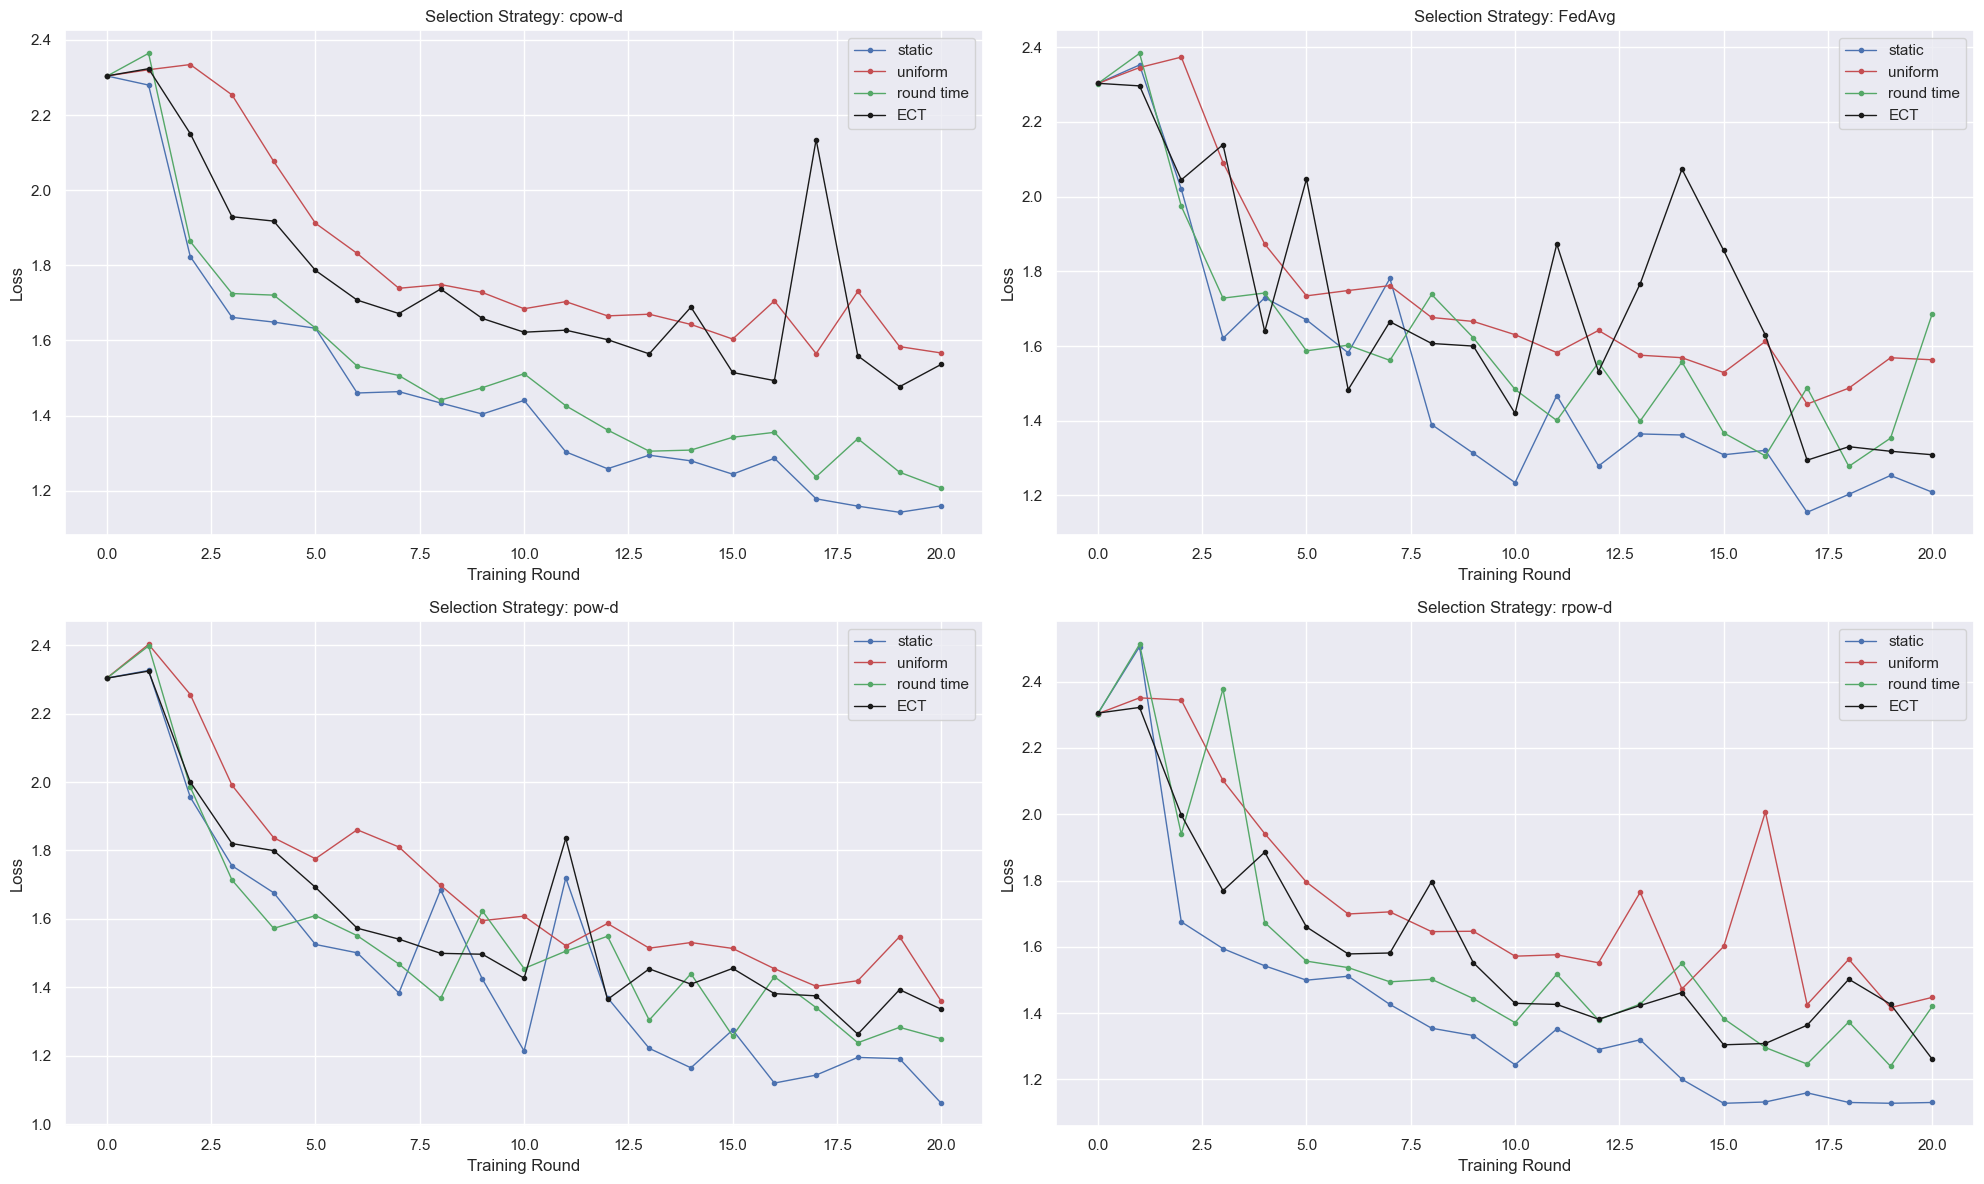

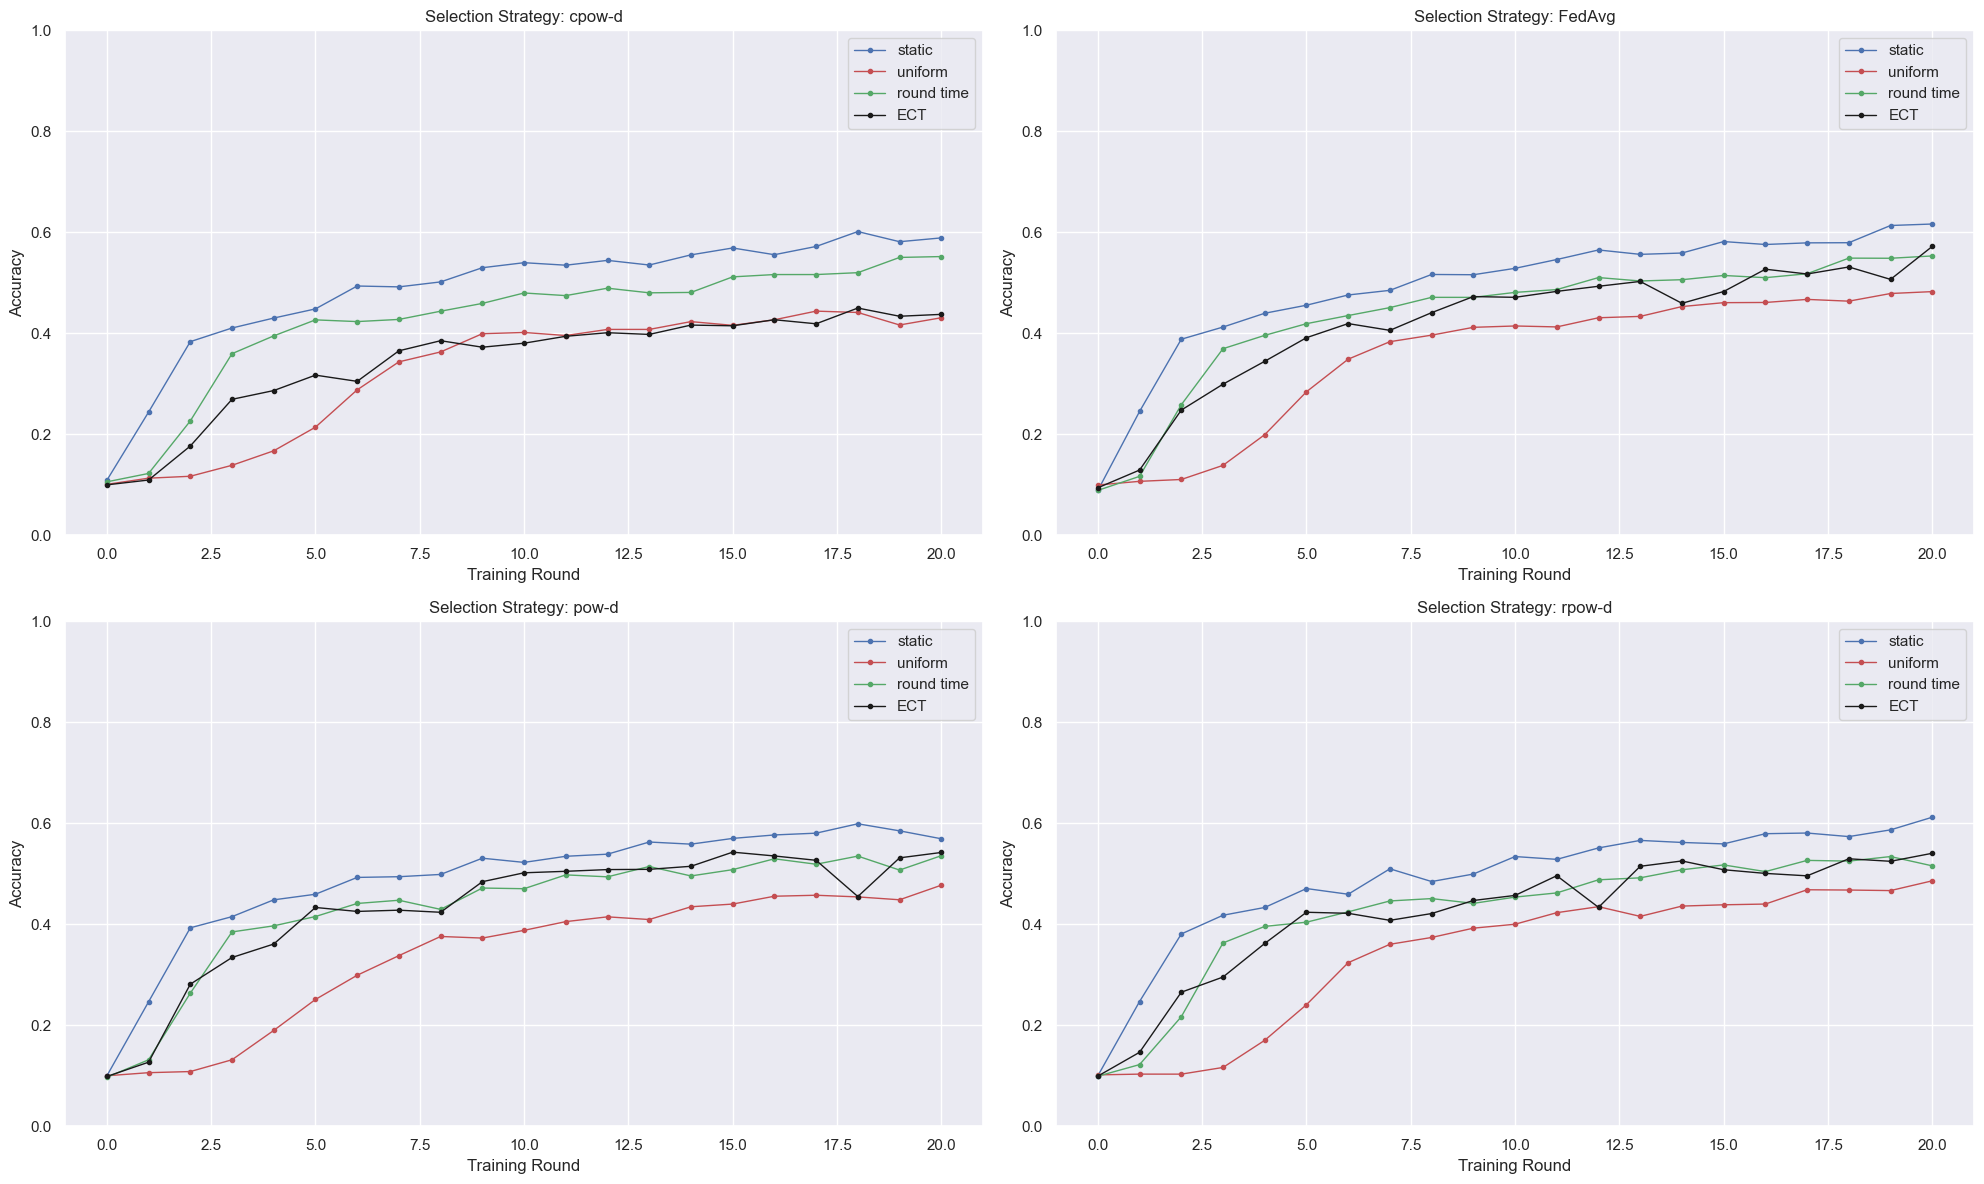

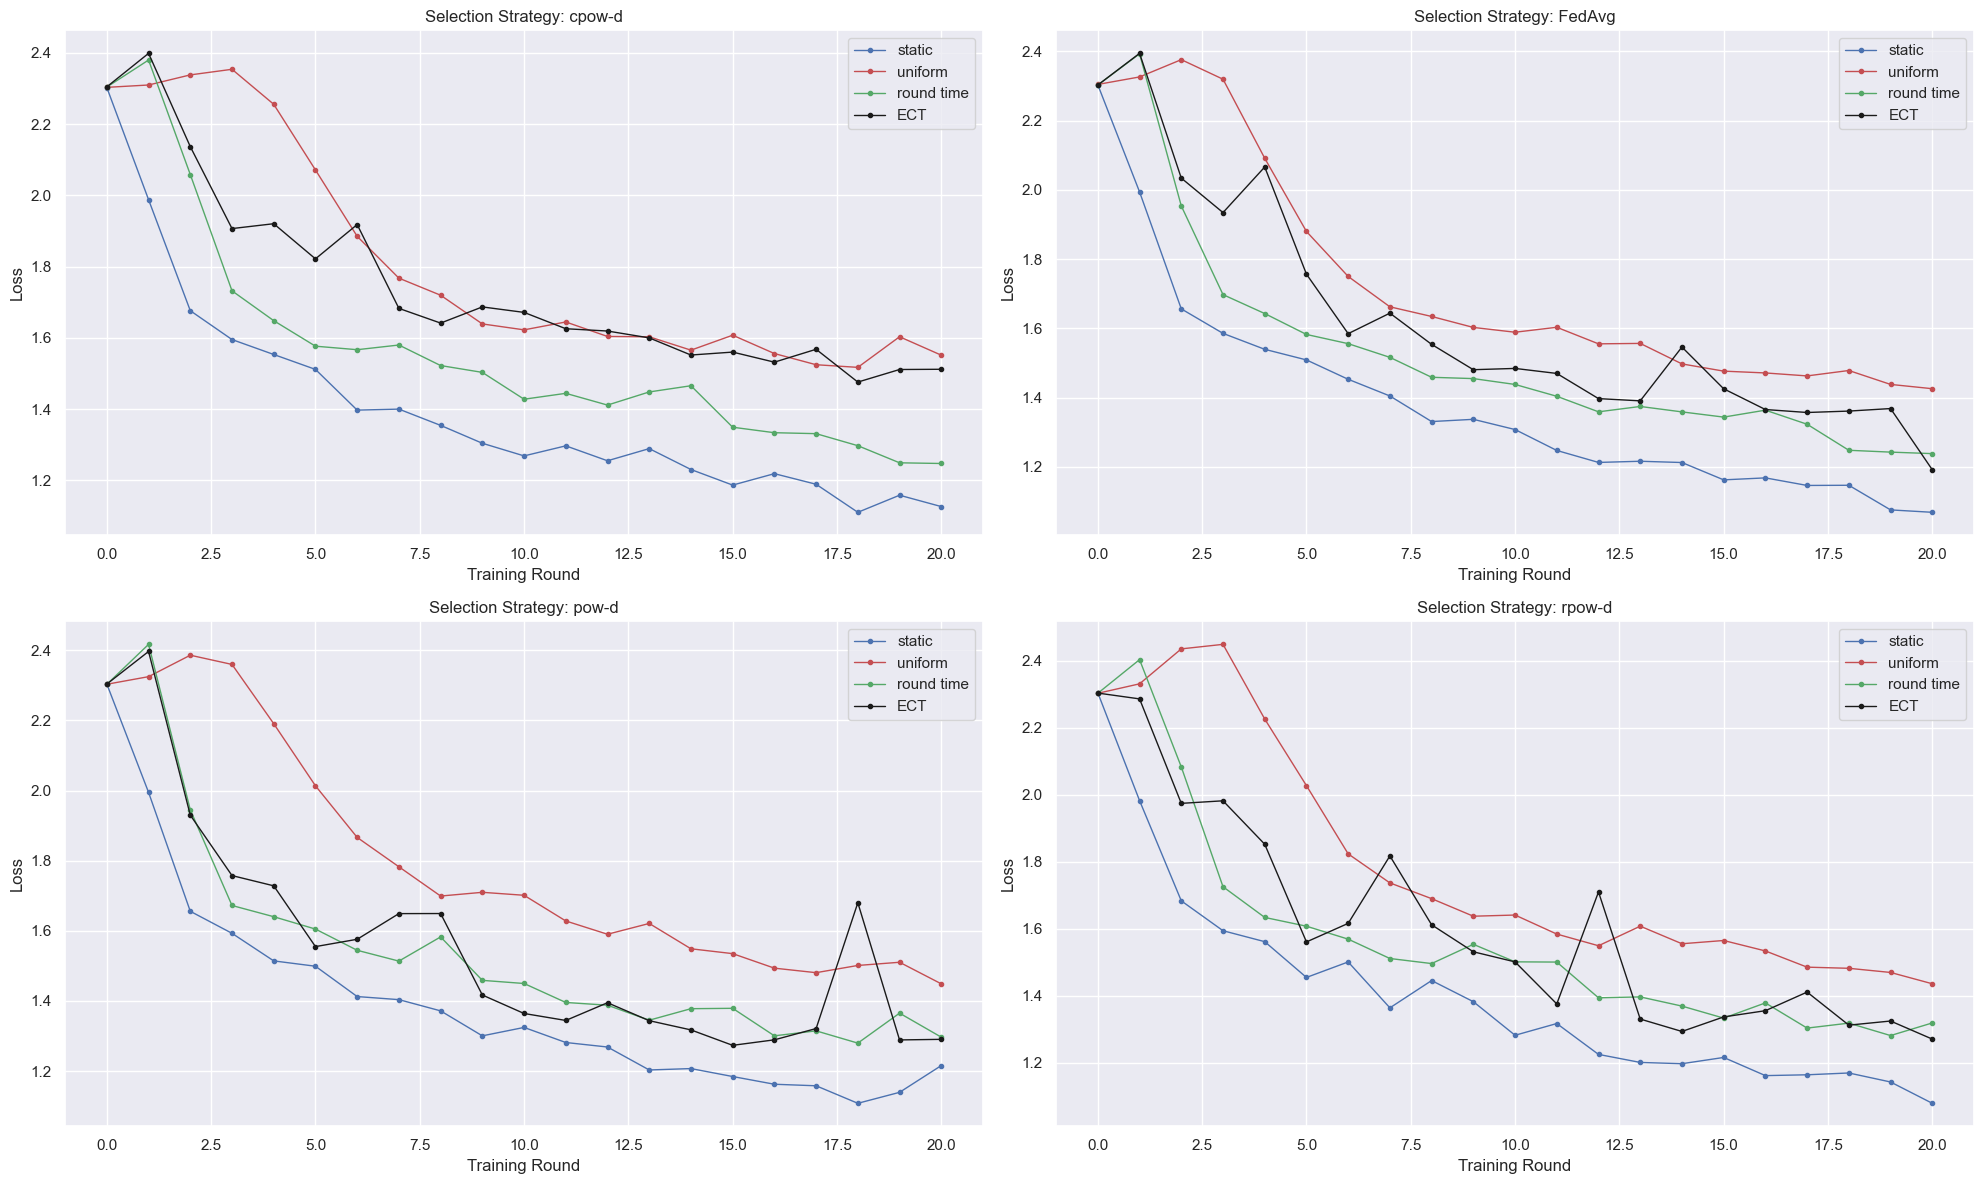

In [7]:
import matplotlib.pyplot as plt

strat_labels = {'rand': 'FedAvg', 'base': 'pow-d', 'cpow': 'cpow-d', 'rpow': 'rpow-d'}
conf_labels = {'so': 'static', 'uo': 'uniform', 'rt': 'round time', 'ecto': 'ECT'}
colors = {'so': 'b', 'uo': 'r', 'rt': 'g', 'ecto': 'k'}

strats = list(set([exp.variant for exp in EXPERIMENTS]))
N = 2

alpha = [0.5, 100.0]

# Plots accuracy and loss split by selection strategy, configuration policy, and value of alpha

for a in alpha:
    fig, ax = plt.subplots(len(strats)//N, N, figsize=(20,12))
        
    for i, strat in enumerate(strats):

        # Calculates avg. accuracy over N replications of the same <selection, configuration, alpha> tuple
        exp_with_strat = [exp for exp in EXPERIMENTS if exp.variant==strat and exp.alpha==a]
        for opt in conf_labels:
            exp_with_strat_and_opt = [exp for exp in exp_with_strat if exp.opt==opt]
            if len(exp_with_strat_and_opt) < 1:
                continue
            avg_accuracy = []
            for j in range(max([exp.rounds for exp in exp_with_strat_and_opt])):
                avg_accuracy.append(sum([results[exp][0][j] for exp in exp_with_strat_and_opt])/len(exp_with_strat_and_opt))

            ax[i//N, i%N].plot(range(max([exp.rounds for exp in exp_with_strat_and_opt])), avg_accuracy, marker='o', linewidth=1, markersize=3, color=colors[opt], label=conf_labels[opt])

        ax[i//N, i%N].set_title('Selection Strategy: {}'.format(strat_labels[strat]))
        ax[i//N, i%N].set_xlabel('Training Round')
        ax[i//N, i%N].set_ylabel('Accuracy')
        ax[i//N, i%N].set_ylim([0, 1])
        ax[i//N, i%N].grid(True)
        ax[i//N, i%N].legend()
    
    # fig.suptitle('Accuracy by <selection strategy, configuration strategy, alpha={}>'.format(a), fontsize=18)
    fig.tight_layout()
    fig.savefig('plots/plot_accuracy_{}.png'.format(a), format='png')
    fig.show()
    
    fig, ax = plt.subplots(len(strats)//N, N, figsize=(20,12))
        
    for i, strat in enumerate(strats):

        # Calculates avg. loss over N replications of the same <selection, configuration, alpha> tuple
        exp_with_strat = [exp for exp in EXPERIMENTS if exp.variant==strat and exp.alpha==a]
        for opt in conf_labels:
            exp_with_strat_and_opt = [exp for exp in exp_with_strat if exp.opt==opt]
            if len(exp_with_strat_and_opt) < 1:
                continue
            avg_accuracy = []
            for j in range(max([exp.rounds for exp in exp_with_strat_and_opt])):
                avg_accuracy.append(sum([results[exp][1][j] for exp in exp_with_strat_and_opt])/len(exp_with_strat_and_opt))

            ax[i//N, i%N].plot(range(max([exp.rounds for exp in exp_with_strat_and_opt])), avg_accuracy, marker='o', linewidth=1, markersize=3, color=colors[opt], label=conf_labels[opt])

        ax[i//N, i%N].set_title('Selection Strategy: {}'.format(strat_labels[strat]))
        ax[i//N, i%N].set_xlabel('Training Round')
        ax[i//N, i%N].set_ylabel('Loss')
        ax[i//N, i%N].grid(True)
        ax[i//N, i%N].legend()
    
    # fig.suptitle('Loss by <selection strategy, configuration strategy, alpha={}>'.format(a), fontsize=18)
    fig.tight_layout()
    fig.savefig('plots/plot_loss_{}.png'.format(a), format='png')
    # fig.show()



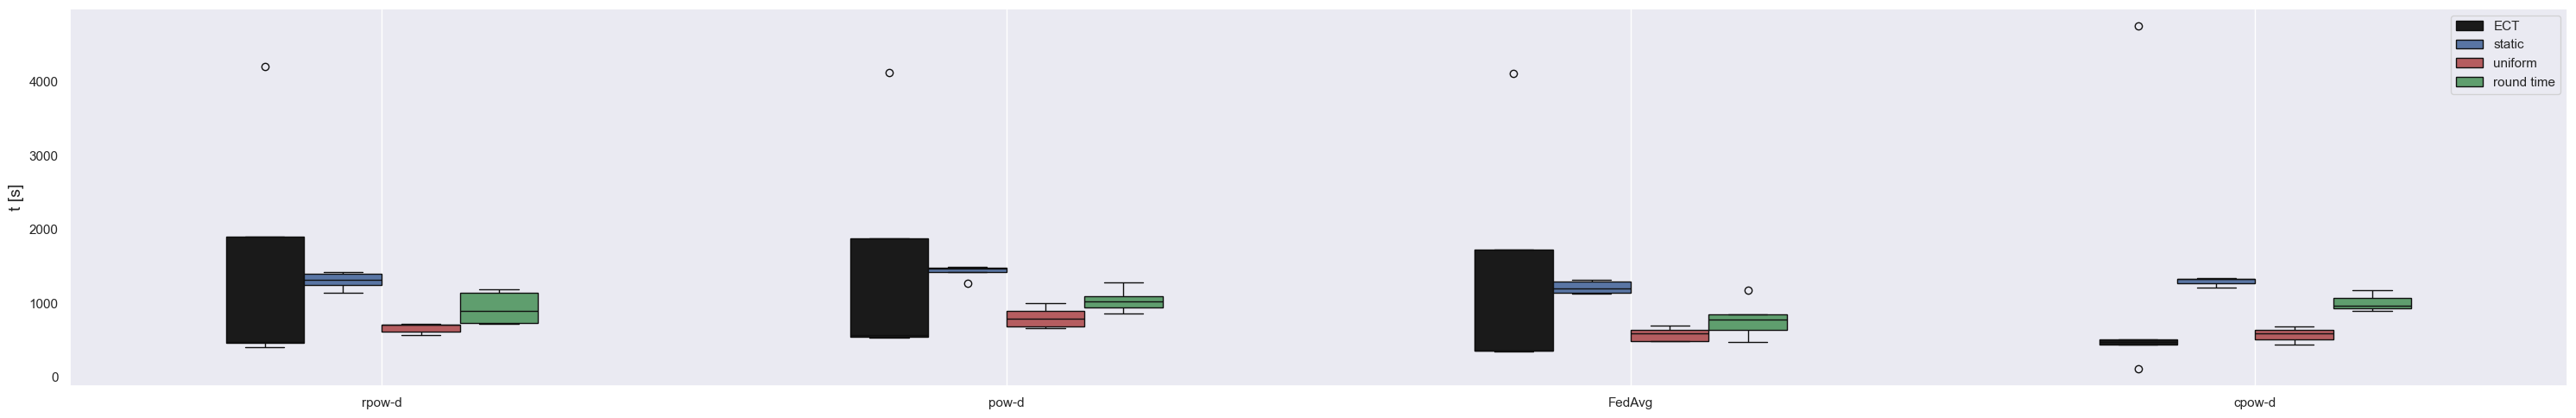

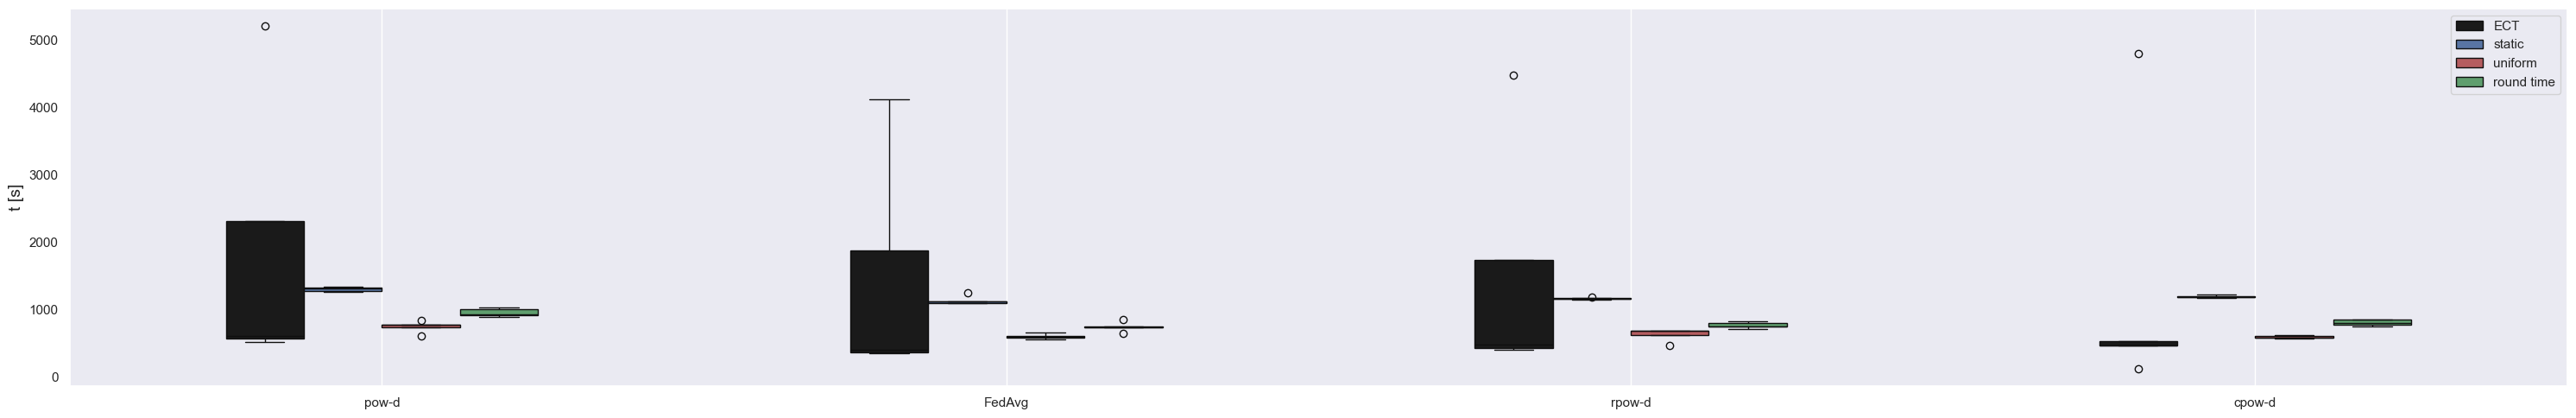

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

strat_labels = {'rand': 'FedAvg', 'base': 'pow-d', 'cpow': 'cpow-d', 'rpow': 'rpow-d'}
conf_labels = {'so': 'static', 'uo': 'uniform', 'rt': 'round time', 'ecto': 'ECT'}
colors = {'static': 'b', 'uniform': 'r', 'round time': 'g', 'ECT': 'k'}
alpha = [0.5, 100.0]

# Plots wall-clock time distributions for each <selection, configuration, alpha> tuple 

for a in alpha:
    x = [strat_labels[exp.variant] for exp in EXPERIMENTS if exp.alpha==a]
    y = [exp.duration for exp in EXPERIMENTS if exp.alpha==a]
    hue = [conf_labels[exp.opt] for exp in EXPERIMENTS if exp.alpha==a]
    
    sns.set_theme(rc={'figure.figsize':(30, 5)})
    sns.boxplot(x=x, y=y, hue=hue, palette=colors, width=0.5)
    # plt.title('Wall-clock time for alpha={}'.format(a), fontsize=14)
    plt.ylabel('t [s]', fontsize=14)
    plt.grid()  
    plt.tight_layout()
    plt.savefig('plots/plot_time_{}.png'.format(a), format='png')
    plt.show()